In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from ai_quantum.utils.matrix_compression import opt_sort_matrix_ring, compress_matrix
from return_cov import f_return_cov
import networkx as nx

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Cov Matrix compression

In [3]:
expected_value

[0.323441,
 0.273809,
 0.796232,
 0.461264,
 0.073279,
 0.341311,
 0.166796,
 0.17193,
 0.128066,
 0.150771]

In [4]:
cov_matrix

0         1         2         3         4         5         6  \
0  0.082140  0.053676  0.077585  0.073628  0.017110  0.023310  0.029083   
1  0.053676  0.072852  0.083743  0.070099  0.017199  0.026280  0.029420   
2  0.077585  0.083743  0.254389  0.177801  0.012236  0.031343  0.034501   
3  0.073628  0.070099  0.177801  0.343955  0.013908  0.028922  0.033770   
4  0.017110  0.017199  0.012236  0.013908  0.033198  0.021540  0.021198   
5  0.023310  0.026280  0.031343  0.028922  0.021540  0.078911  0.026038   
6  0.029083  0.029420  0.034501  0.033770  0.021198  0.026038  0.069392   
7  0.032363  0.032264  0.044786  0.043298  0.018661  0.018474  0.031054   
8  0.036382  0.036004  0.050281  0.052788  0.019928  0.019272  0.034265   
9  0.038377  0.037562  0.057511  0.054436  0.017888  0.019448  0.032163   

          7         8         9  
0  0.032363  0.036382  0.038377  
1  0.032264  0.036004  0.037562  
2  0.044786  0.050281  0.057511  
3  0.043298  0.052788  0.054436  
4  0.018661  0.019928  0.017888  
5  0.018474  0.019272  0.019448  
6  0.031054  0.034265  0.032163  
7  0.077202  0.078073  0.067586  
8  0.078073  0.099412  0.076724  
9  0.067586  0.076724  0.087179

In [5]:
opt_perm = opt_sort_matrix_ring(np.array(cov_matrix))

q_graph = [
 (opt_perm[i], opt_perm[np.mod(i+1, len(expected_value))]) 
 for i in range(len(expected_value))
]
q_graph.append((2, 0))
q_graph

[(1, 2),
 (2, 3),
 (3, 0),
 (0, 9),
 (9, 8),
 (8, 7),
 (7, 6),
 (6, 4),
 (4, 5),
 (5, 1),
 (2, 0)]

In [6]:
G = nx.Graph()
G.add_edges_from(q_graph)
lam, compress_cov_matrix = compress_matrix(cov_matrix[opt_perm], G)
compress_cov_matrix = pd.DataFrame(compress_cov_matrix)

## ----------

In [7]:
# Define the objective function to be optimized
q = 0.5 
B  = 2 
lamb= 0
depth = 40
qc_initial_state = dicke_statevector(len(expected_value), B)
def objective(params):
    gamma = params[:depth]
    beta = params[depth:]
    qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb,
                qc=qc_initial_state, mixture_layer='ring_mixer', q_graph=q_graph)
    for i in range(depth):
        qaoa.add_layer(gamma[i], beta[i])

    energy, _ = qaoa.measure_energy()
    return energy

# Specify the initial parameters for optimization.
vec_gamma = []
vec_beta = []
initial_params = []
for _ in range(depth):
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, 2*np.pi)
    vec_gamma.append(gamma)
    vec_beta.append(beta)
    initial_params.append(gamma)
    initial_params.append(beta)

## Global optimal solution

In [8]:
from ai_quantum.utils.cost_function import sort_by_cost_function

In [9]:
df = sort_by_cost_function(expected_value, cov_matrix, q, lamb, B)
df = df[df.apply({'solution': lambda s: np.sum(s)==2}).values]
df = df.reset_index(drop=True)

In [35]:
df.head(10)

solution  cost_function
0  (0, 0, 1, 0, 0, 1, 0, 0, 0, 0)      -0.939550
1  (1, 0, 1, 0, 0, 0, 0, 0, 0, 0)      -0.873824
2  (0, 1, 1, 0, 0, 0, 0, 0, 0, 0)      -0.822678
3  (0, 0, 1, 1, 0, 0, 0, 0, 0, 0)      -0.780523
4  (0, 0, 1, 0, 0, 0, 1, 0, 0, 0)      -0.766636
5  (0, 0, 1, 0, 0, 0, 0, 1, 0, 0)      -0.757581
6  (0, 0, 1, 0, 0, 0, 0, 0, 0, 1)      -0.718708
7  (0, 0, 1, 0, 1, 0, 0, 0, 0, 0)      -0.713482
8  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0)      -0.697117
9  (0, 0, 0, 1, 0, 1, 0, 0, 0, 0)      -0.562220

In [23]:
index_filter = df['solution']==(1, 0, 1, 0, 0, 0, 0, 0, 0, 0)
df[index_filter]

solution  cost_function
1  (1, 0, 1, 0, 0, 0, 0, 0, 0, 0)      -0.873824

In [24]:
index_filter = df['solution']==(0, 0, 1, 0, 0, 1, 0, 0, 0, 0)
df[index_filter]

solution  cost_function
0  (0, 0, 1, 0, 0, 1, 0, 0, 0, 0)       -0.93955

In [25]:
index_filter = df['solution']==(0, 0, 1, 0, 0, 0, 0, 1, 0, 0)	
df[index_filter]

solution  cost_function
5  (0, 0, 1, 0, 0, 0, 0, 1, 0, 0)      -0.757581

In [36]:
df_sdp = sort_by_cost_function(expected_value, compress_cov_matrix, q, lamb, B)
df_sdp = df_sdp[df_sdp.apply({'solution': lambda s: np.sum(s)==2}).values]
df_sdp = df_sdp.reset_index(drop=True)

In [37]:
df_sdp.head(10)

solution  cost_function
0  (0, 0, 1, 0, 0, 1, 0, 0, 0, 0)      -1.091283
1  (1, 0, 1, 0, 0, 0, 0, 0, 0, 0)      -1.013351
2  (0, 0, 1, 0, 0, 0, 0, 1, 0, 0)      -0.936046
3  (0, 0, 1, 0, 0, 0, 1, 0, 0, 0)      -0.923589
4  (0, 0, 1, 0, 0, 0, 0, 0, 0, 1)      -0.917627
5  (0, 0, 1, 1, 0, 0, 0, 0, 0, 0)      -0.917122
6  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0)      -0.889538
7  (0, 0, 1, 0, 1, 0, 0, 0, 0, 0)      -0.850743
8  (0, 1, 1, 0, 0, 0, 0, 0, 0, 0)      -0.746332
9  (0, 0, 0, 1, 0, 1, 0, 0, 0, 0)      -0.730614

## --------

In [10]:
result = minimize(objective, initial_params, method='COBYLA')

gamma = result.x[:depth]
beta = result.x[depth:]

In [11]:
# Generate the optimal circuit.
qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb)
         #   qc=qc_initial_state, mixture_layer='ring_mixer', q_graph=q_graph)
for i in range(depth):
    qaoa.add_layer(gamma[i], beta[i])
    
energy, counts = qaoa.measure_energy()
energy

np.float64(-0.37788246175491563)

In [53]:
compress_cov_matrix.round(2)

0     1     2     3     4     5     6     7     8     9
0  0.06 -0.00  0.00  0.10 -0.00  0.00  0.00 -0.00  0.00  0.04
1 -0.00  0.16  0.23 -0.00  0.00 -0.03  0.00  0.00 -0.00 -0.00
2  0.00  0.23  0.12  0.33 -0.00  0.00  0.00 -0.00  0.00 -0.00
3  0.10 -0.00  0.33  0.11  0.00  0.00 -0.00  0.00 -0.00 -0.00
4 -0.00  0.00 -0.00  0.00 -0.00  0.05  0.09  0.00  0.00  0.00
5  0.00 -0.03  0.00  0.00  0.05  0.10 -0.00 -0.00 -0.00 -0.00
6  0.00  0.00  0.00 -0.00  0.09 -0.00  0.02  0.21  0.00  0.00
7 -0.00  0.00 -0.00  0.00  0.00 -0.00  0.21  0.01  0.10  0.00
8  0.00 -0.00  0.00 -0.00  0.00 -0.00  0.00  0.10  0.02  0.05
9  0.04 -0.00 -0.00 -0.00  0.00 -0.00  0.00  0.00  0.05  0.04

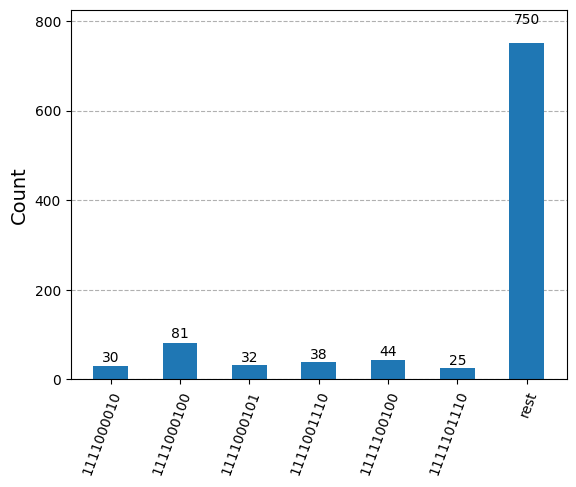

In [14]:
plot_histogram(counts, number_to_keep=6)
plt.show()

In [12]:
qaoa.draw()